In [10]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix,  f1_score
import seaborn as sns
from tqdm import tqdm
import shutil

In [11]:
# --- CONFIGURATION ---
DATA_ROOT = r"C:\Users\Brandon\Documents\DM_Project\ucf_crime_v2"  # Your root folder
NORMAL_CLASS_NAME = "NormalVideos" # Change this if your folder is named 'Normal_Videos_event'
STAGE_2_DATA_ROOT = "stage2_extracted_frames" # Where we will save frames for Stage 2

# Hyperparameters
BATCH_SIZE = 8
NUM_SEGMENTS = 16  # How many clips/frames to sample per video in Stage 1
IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TOP_N_FRAMES = 5   # How many "evidence" frames to extract per video for Stage 2

print(f"Running on device: {DEVICE}")

Running on device: cuda


In [12]:
class UCFCrimeBinaryDataset(Dataset):
    def __init__(self, root_dir, split="Train", num_segments=16, transform=None):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.num_segments = num_segments
        self.samples = [] 
        
        # Walk through directories
        for class_name in os.listdir(self.root_dir):
            class_path = os.path.join(self.root_dir, class_name)
            if not os.path.isdir(class_path): continue
            
            # Binary Label: 0 if Normal, 1 if Crime
            label = 0 if class_name == NORMAL_CLASS_NAME else 1
            
            for vid_file in os.listdir(class_path):
                self.samples.append((os.path.join(class_path, vid_file), label, class_name))

    def __len__(self):
        return len(self.samples)

    def load_video_segments(self, path):
        cap = cv2.VideoCapture(path)
        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        if total_frames < 1: return torch.zeros(self.num_segments, 3, IMG_SIZE, IMG_SIZE)

        # Uniform sampling
        indices = np.linspace(0, total_frames-1, self.num_segments).astype(int)
        
        for idx in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                if self.transform:
                    frame = self.transform(frame)
                frames.append(frame)
            else:
                # Padding if read fails
                frames.append(torch.zeros(3, IMG_SIZE, IMG_SIZE))
        cap.release()
        
        # Stack to shape (Segments, C, H, W)
        return torch.stack(frames) if frames else torch.zeros(self.num_segments, 3, IMG_SIZE, IMG_SIZE)

    def __getitem__(self, idx):
        path, label, original_class = self.samples[idx]
        video_tensor = self.load_video_segments(path) # Shape: (T, C, H, W)
        return video_tensor, torch.tensor(label, dtype=torch.float32), path, original_class

# --- STAGE 1 MODEL: MIL ResNet ---
class Stage1MILModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Feature Extractor (ResNet18)
        resnet = models.resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1]) # Remove fc
        
        # Classifier Head (Instance Level)
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x shape: (Batch, Segments, C, H, W)
        b, t, c, h, w = x.size()
        
        # Merge Batch and Time for CNN processing
        x = x.view(b * t, c, h, w) 
        
        features = self.feature_extractor(x) # (B*T, 512, 1, 1)
        features = features.view(features.size(0), -1) # (B*T, 512)
        
        # Get instance (segment) scores
        segment_scores = self.classifier(features) # (B*T, 1)
        
        # Reshape back to (Batch, Segments)
        segment_scores = segment_scores.view(b, t)
        
        # MIL Aggregation: Max Pooling (The video score is the max segment score)
        # We return both the video score AND the segment scores (for frame extraction)
        video_score, _ = torch.max(segment_scores, dim=1)
        
        return video_score, segment_scores

In [ ]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Loaders
train_ds_s1 = UCFCrimeBinaryDataset(DATA_ROOT, split="Train", transform=transform)
test_ds_s1 = UCFCrimeBinaryDataset(DATA_ROOT, split="Test", transform=transform)
train_loader_s1 = DataLoader(train_ds_s1, batch_size=BATCH_SIZE, shuffle=True)
test_loader_s1 = DataLoader(test_ds_s1, batch_size=1, shuffle=False) # Batch 1 for easier extraction

# Init Model
model_s1 = Stage1MILModel().to(DEVICE)
optimizer_s1 = optim.Adam(model_s1.parameters(), lr=1e-4)
criterion_s1 = nn.BCELoss()

# --- TRAINING LOOP STAGE 1 ---
def train_stage1(epochs=1):
    model_s1.train()
    history = {'train_loss': [], 'train_acc': [], 'train_f1': []}
    
    for epoch in range(epochs):
        epoch_loss = 0
        all_preds = []
        all_labels = []
        
        loop = tqdm(train_loader_s1, desc=f"Stage 1 Epoch {epoch+1}")
        for videos, labels, _, _ in loop:
            videos, labels = videos.to(DEVICE), labels.to(DEVICE)
            
            optimizer_s1.zero_grad()
            video_preds, _ = model_s1(videos)
            
            loss = criterion_s1(video_preds, labels)
            loss.backward()
            optimizer_s1.step()
            
            epoch_loss += loss.item()
            
            # Track predictions for metrics
            preds_binary = (video_preds > 0.5).float()
            all_preds.extend(preds_binary.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            loop.set_postfix(loss=loss.item())
        
        # Calculate epoch metrics
        avg_loss = epoch_loss / len(train_loader_s1)
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='binary')
        
        history['train_loss'].append(avg_loss)
        history['train_acc'].append(accuracy)
        history['train_f1'].append(f1)
        
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Acc: {accuracy:.4f}, F1: {f1:.4f}")
    
    return history

# Run Training
print("Starting Stage 1 Training...")
stage1_history = train_stage1(epochs=6) # Increase epochs for real results

# --- THE PIPE: EXTRACTION ---
# We will iterate through the dataset. If the model says "Crime" (or if it IS a crime in training),
# we extract top N frames and save them for Stage 2.

def extract_frames_for_stage2(dataset, split_name):
    print(f"Extracting frames for {split_name}...")
    model_s1.eval()
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    with torch.no_grad():
        for videos, labels, paths, original_classes in tqdm(loader):
            videos = videos.to(DEVICE)
            path = paths[0]
            orig_class = original_classes[0]
            
            # Skip Normal videos for Stage 2 (we only want to classify crime types)
            if orig_class == NORMAL_CLASS_NAME:
                continue

            # Get scores
            video_score, segment_scores = model_s1(videos)
            
            # Identify Top N indices
            # segment_scores is shape (1, 16)
            scores = segment_scores[0].cpu().numpy()
            top_indices = scores.argsort()[-TOP_N_FRAMES:][::-1] # Indices of highest scores
            
            # Prepare save directory
            # e.g., stage2_extracted/Train/Abuse/
            save_dir = os.path.join(STAGE_2_DATA_ROOT, split_name, orig_class)
            os.makedirs(save_dir, exist_ok=True)
            
            # Extract actual frames from video file using the indices
            cap = cv2.VideoCapture(path)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            # Map segment index back to frame number
            frame_indices_to_grab = np.linspace(0, total_frames-1, NUM_SEGMENTS).astype(int)[top_indices]
            
            vid_name = os.path.basename(path).split('.')[0]
            
            for rank, frame_idx in enumerate(frame_indices_to_grab):
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                ret, frame = cap.read()
                if ret:
                    save_path = os.path.join(save_dir, f"{vid_name}_rank{rank}.jpg")
                    cv2.imwrite(save_path, frame)
            cap.release()

# Run Extraction
extract_frames_for_stage2(train_ds_s1, "Train")
extract_frames_for_stage2(test_ds_s1, "Test")

c:\Users\Brandon\anaconda3\envs\ucf_crime_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Brandon\anaconda3\envs\ucf_crime_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting Stage 1 Training...


Stage 1 Epoch 1: 100%|██████████| 117/117 [03:19<00:00,  1.71s/it, loss=0.364] 


Epoch 1/6 - Loss: 0.3704, Acc: 0.8452, F1: 0.9107


Stage 1 Epoch 2: 100%|██████████| 117/117 [03:10<00:00,  1.63s/it, loss=0.0608]


Epoch 2/6 - Loss: 0.2433, Acc: 0.9194, F1: 0.9518


Stage 1 Epoch 3: 100%|██████████| 117/117 [03:09<00:00,  1.62s/it, loss=0.00822]


Epoch 3/6 - Loss: 0.1810, Acc: 0.9258, F1: 0.9549


Stage 1 Epoch 4: 100%|██████████| 117/117 [03:09<00:00,  1.62s/it, loss=0.00352]


Epoch 4/6 - Loss: 0.1234, Acc: 0.9505, F1: 0.9699


Stage 1 Epoch 5: 100%|██████████| 117/117 [03:09<00:00,  1.62s/it, loss=0.838] 


Epoch 5/6 - Loss: 0.1254, Acc: 0.9548, F1: 0.9725


Stage 1 Epoch 6: 100%|██████████| 117/117 [03:10<00:00,  1.62s/it, loss=0.216] 


Epoch 6/6 - Loss: 0.1662, Acc: 0.9387, F1: 0.9623
Extracting frames for Train...


100%|██████████| 930/930 [03:47<00:00,  4.09it/s]


Extracting frames for Test...


100%|██████████| 245/245 [00:56<00:00,  4.33it/s]


Evaluating Stage 1: 100%|██████████| 245/245 [00:50<00:00,  4.81it/s]


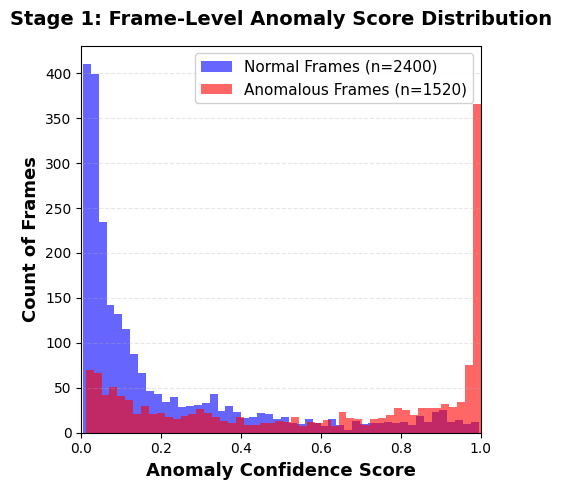

Stage 1 Test Accuracy: 75.51%
Stage 1 Test F1 Score: 0.7170


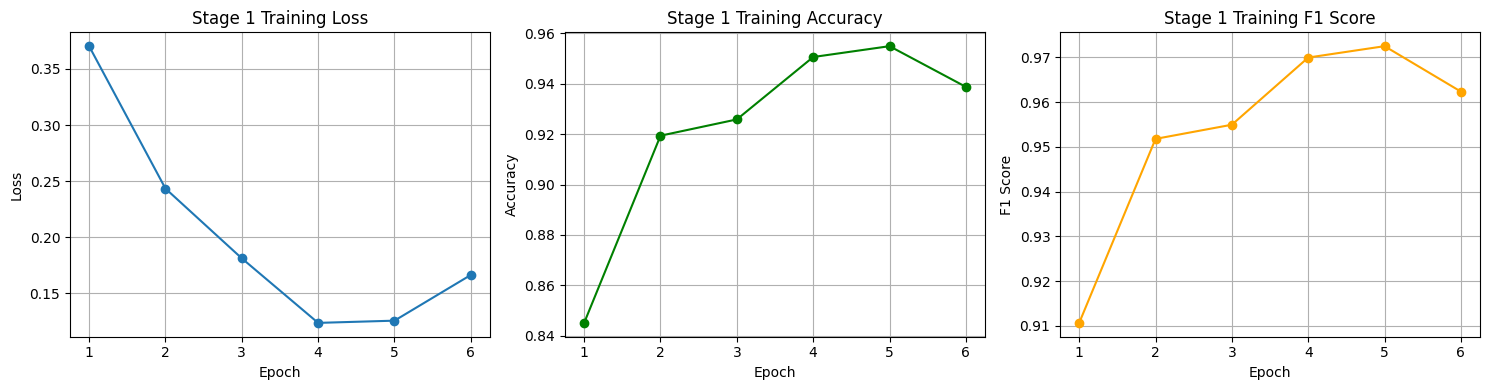

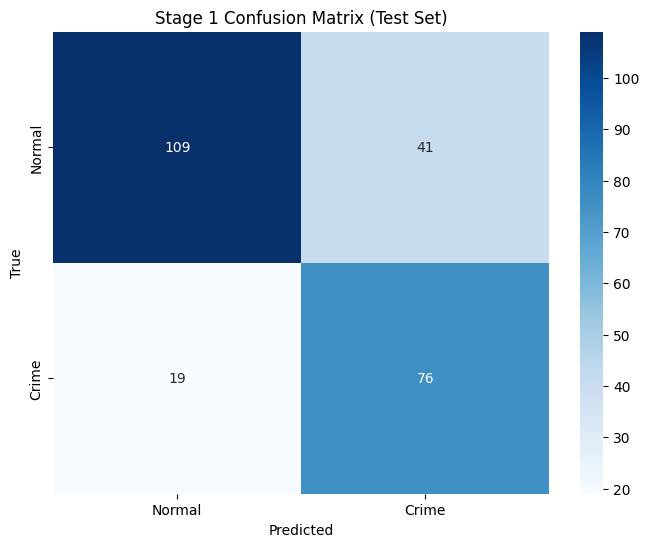

In [52]:
# --- STAGE 1 EVALUATION AND VISUALIZATION ---

def evaluate_stage1(loader, model, num_segments=16, plot_distribution=True, bins=50):
    """
    Evaluate Stage 1 model and optionally plot frame-level anomaly score distribution.
    
    Args:
        loader: DataLoader for evaluation
        model: Trained Stage 1 model
        num_segments: Number of segments per video
        plot_distribution: Whether to plot the frame-level score distribution
        bins: Number of bins for histogram
    
    Returns:
        acc, f1, cm, all_preds, all_labels, normal_frame_scores, anomaly_frame_scores
    """
    model.eval()
    all_preds = []
    all_labels = []
    normal_frame_scores = []
    anomaly_frame_scores = []
    
    with torch.no_grad():
        for videos, labels, _, _ in tqdm(loader, desc="Evaluating Stage 1"):
            videos, labels = videos.to(DEVICE), labels.to(DEVICE)
            video_preds, segment_scores = model(videos)
            preds_binary = (video_preds > 0.5).float()
            
            all_preds.extend(preds_binary.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Collect frame-level scores for distribution
            for i in range(len(labels)):
                scores = segment_scores[i].cpu().numpy()
                
                if labels[i].item() == 0:  # Normal
                    normal_frame_scores.extend(scores)
                else:  # Anomaly
                    anomaly_frame_scores.extend(scores)
    
    # Convert to numpy arrays
    normal_frame_scores = np.array(normal_frame_scores)
    anomaly_frame_scores = np.array(anomaly_frame_scores)
    
    # Calculate video-level metrics
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='binary')
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot frame-level anomaly score distribution
    if plot_distribution:
        fig, ax = plt.subplots(figsize=(5, 5))
        
        # Create histograms
        ax.hist(normal_frame_scores, bins=bins, alpha=0.6, color='blue', 
                label=f'Normal Frames (n={len(normal_frame_scores)})', linewidth=0.5)
        ax.hist(anomaly_frame_scores, bins=bins, alpha=0.6, color='red', 
                label=f'Anomalous Frames (n={len(anomaly_frame_scores)})', linewidth=0.5)
        
        # Labels and title
        ax.set_xlabel('Anomaly Confidence Score', fontsize=13, fontweight='bold')
        ax.set_ylabel('Count of Frames', fontsize=13, fontweight='bold')
        ax.set_title('Stage 1: Frame-Level Anomaly Score Distribution', 
                     fontsize=14, fontweight='bold', pad=15)
        
        # Add grid and legend
        ax.grid(True, alpha=0.3, linestyle='--', axis='y')
        ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
        
        # Set x-axis limits
        ax.set_xlim(0, 1)
        
        
        plt.tight_layout()
        plt.show()
        
    
    return acc, f1, cm, all_preds, all_labels, normal_frame_scores, anomaly_frame_scores


# Evaluate on test set (now includes frame-level distribution)
test_acc, test_f1, test_cm, test_preds, test_labels, normal_scores, anomaly_scores = evaluate_stage1(
    test_loader_s1, model_s1, num_segments=NUM_SEGMENTS, plot_distribution=True, bins=50
)

print(f"Stage 1 Test Accuracy: {test_acc*100:.2f}%")
print(f"Stage 1 Test F1 Score: {test_f1:.4f}")

# Plot training metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss plot
axes[0].plot(range(1, len(stage1_history['train_loss'])+1), stage1_history['train_loss'], marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Stage 1 Training Loss')
axes[0].grid(True)

# Accuracy plot
axes[1].plot(range(1, len(stage1_history['train_acc'])+1), stage1_history['train_acc'], marker='o', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Stage 1 Training Accuracy')
axes[1].grid(True)

# F1 Score plot
axes[2].plot(range(1, len(stage1_history['train_f1'])+1), stage1_history['train_f1'], marker='o', color='orange')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('Stage 1 Training F1 Score')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='d', xticklabels=['Normal', 'Crime'], yticklabels=['Normal', 'Crime'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Stage 1 Confusion Matrix (Test Set)')
plt.show()


In [25]:
# --- STAGE 1: VIDEO CONFIDENCE OVER TIME VISUALIZATION ---

def get_video_confidence_timeline(model, video_path, num_segments=16, top_n=5):
    """
    Extract frame-by-frame confidence scores for a video.
    Returns frame indices, confidence scores, and top N frame indices.
    """
    model.eval()
    
    # Load video and get all sampled frames
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if total_frames < 1:
        cap.release()
        return None, None, None
    
    # Get the frame indices that were sampled
    frame_indices = np.linspace(0, total_frames-1, num_segments).astype(int)
    
    # Load and process each frame
    frames = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)
            frame = transform(frame)
            frames.append(frame)
        else:
            frames.append(torch.zeros(3, IMG_SIZE, IMG_SIZE))
    
    cap.release()
    
    # Stack frames and get predictions
    video_tensor = torch.stack(frames).unsqueeze(0).to(DEVICE)  # Shape: (1, T, C, H, W)
    
    with torch.no_grad():
        video_score, segment_scores = model(video_tensor)
    
    # Get segment scores (confidence of being anomalous/crime)
    segment_scores = segment_scores[0].cpu().numpy()  # Shape: (num_segments,)
    
    # Get top N frame indices
    top_indices = segment_scores.argsort()[-top_n:][::-1]
    top_frame_numbers = frame_indices[top_indices]
    
    return frame_indices, segment_scores, top_frame_numbers, video_score.item()


In [47]:
def plot_video_confidence_timeline(video_name, model, test_dataset, save_path=None):
    """
    Plot the confidence timeline for a specific video by name.
    
    Args:
        video_name: Name of the video file (e.g., "Abuse001_x264.mp4")
        model: Trained Stage 1 model
        test_dataset: The test dataset object
        save_path: Optional path to save the figure
    """
    # Find the video in the dataset
    video_path = None
    video_label = None
    video_class = None
    
    for path, label, orig_class in test_dataset.samples:
        if video_name in path:
            video_path = path
            video_label = label
            video_class = orig_class
            break
    
    if video_path is None:
        print(f"Video '{video_name}' not found in test dataset!")
        return
    
    # Get confidence timeline
    frame_indices, confidences, top_frames, overall_score = get_video_confidence_timeline(
        model, video_path, num_segments=NUM_SEGMENTS, top_n=TOP_N_FRAMES
    )
    
    if frame_indices is None:
        print(f"Failed to process video: {video_name}")
        return
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Plot confidence scores (no markers on the line itself)
    ax.plot(frame_indices, confidences, linewidth=2, color='#2E86AB', label='Anomaly Confidence')
    
    # Add markers only on the top N frames
    top_frame_confidences = confidences[np.isin(frame_indices, top_frames)]
    ax.plot(top_frames, top_frame_confidences, '|', markersize=8, color='#2E86AB', markeredgecolor='#2E86AB', markeredgewidth=1.5, label='Top Evidence Frames', zorder=5)
    
    # Add horizontal line at 0.5 threshold
    ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold (0.5)')
    
    # Group sequential top frames and highlight them
    # Sort top frames to check for sequential frames
    sorted_top_frames = np.sort(top_frames)
    
    # Find groups of sequential frames
    groups = []
    current_group = [sorted_top_frames[0]]
    
    for i in range(1, len(sorted_top_frames)):
        # Check if frames are adjacent in the original frame_indices
        current_idx = np.where(frame_indices == sorted_top_frames[i])[0][0]
        prev_idx = np.where(frame_indices == sorted_top_frames[i-1])[0][0]
        
        if current_idx - prev_idx == 1:  # Sequential frames
            current_group.append(sorted_top_frames[i])
        else:
            groups.append(current_group)
            current_group = [sorted_top_frames[i]]
    
    groups.append(current_group)  # Add the last group
    
    # Highlight each group with merged bars
    y_min, y_max = ax.get_ylim()
    for i, group in enumerate(groups):
        # For each group, create one wide bar that spans all frames
        start_frame = group[0] - 10
        end_frame = group[-1] + 10
        ax.axvspan(start_frame, end_frame, alpha=0.15, color="#FF0000", 
                   label='Top Evidence Region' if i == 0 else '')
    
    # Labels and title
    ax.set_xlabel('Frame Number', fontsize=12, fontweight='bold')
    ax.set_ylabel('Anomaly Confidence Score', fontsize=12, fontweight='bold')
    
    true_label = "Normal" if video_label == 0 else "Anomalous"
    pred_label = "Anomalous" if overall_score > 0.5 else "Normal"
    
    title = f'Video Anomaly Confidence Timeline\n'
    title += f'Video: {video_name} | True Label: {true_label} ({video_class}) | '
    title += f'Predicted: {pred_label} (Score: {overall_score:.3f})'
    ax.set_title(title, fontsize=13, fontweight='bold', pad=15)
    
    # Add grid and legend
    ax.grid(True, alpha=0.5, linestyle='--', linewidth=0.8, color='gray')
    ax.legend(loc='upper left', fontsize=10)
    
    # Set axis limits to match the data range
    ax.set_xlim(frame_indices[0], frame_indices[-1])
    ax.set_ylim(-0.05, 1.05)
    
    # Add axis spines (borders) for x and y axes
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['bottom'].set_color('black')
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['right'].set_color('black')
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['top'].set_color('black')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    plt.show()
    
    # Print summary statistics
    print(f"\n{'='*60}")
    print(f"Video: {video_name}")
    print(f"True Label: {true_label} ({video_class})")
    print(f"Overall Anomaly Score: {overall_score:.4f}")
    print(f"Prediction: {pred_label}")
    print(f"\nTop {TOP_N_FRAMES} Evidence Frames:")
    for i, (frame_num, score) in enumerate(zip(top_frames, confidences[np.isin(frame_indices, top_frames)])):
        print(f"  #{i+1}: Frame {frame_num} (Confidence: {score:.4f})")
    print(f"{'='*60}\n")

In [27]:
def list_test_videos(test_dataset, class_filter=None, limit=10):
    """
    List available videos in the test dataset.
    
    Args:
        test_dataset: The test dataset object
        class_filter: Optional class name to filter by (e.g., "Abuse", "NormalVideos")
        limit: Maximum number of videos to display
    """
    print(f"Available test videos (showing up to {limit}):\n")
    print(f"{'Video Name':<40} {'Class':<20} {'Label'}")
    print("-" * 70)
    
    count = 0
    for path, label, orig_class in test_dataset.samples:
        if class_filter and orig_class != class_filter:
            continue
        
        video_name = os.path.basename(path)
        label_str = "Normal" if label == 0 else "Anomalous"
        print(f"{video_name:<40} {orig_class:<20} {label_str}")
        
        count += 1
        if count >= limit:
            break
    
    print(f"\nTotal videos in test set: {len(test_dataset.samples)}")
    if class_filter:
        filtered_count = sum(1 for _, _, c in test_dataset.samples if c == class_filter)
        print(f"Videos in '{class_filter}': {filtered_count}")

# Example: List all test videos
# list_test_videos(test_ds_s1, limit=20)

# Example: List only crime videos
# list_test_videos(test_ds_s1, class_filter="Abuse", limit=10)

In [21]:
list_test_videos(test_ds_s1, limit=20)

Available test videos (showing up to 20):

Video Name                               Class                Label
----------------------------------------------------------------------
Abuse003_x264.mp4                        Abuse                Anomalous
Abuse011_x264.mp4                        Abuse                Anomalous
Abuse013_x264.mp4                        Abuse                Anomalous
Abuse039_x264.mp4                        Abuse                Anomalous
Abuse047_x264.mp4                        Abuse                Anomalous
Arrest013_x264.mp4                       Arrest               Anomalous
Arrest015_x264.mp4                       Arrest               Anomalous
Arrest023_x264.mp4                       Arrest               Anomalous
Arrest024_x264.mp4                       Arrest               Anomalous
Arrest046_x264.mp4                       Arrest               Anomalous
Arson012_x264.mp4                        Arson                Anomalous
Arson021_x264.mp4         

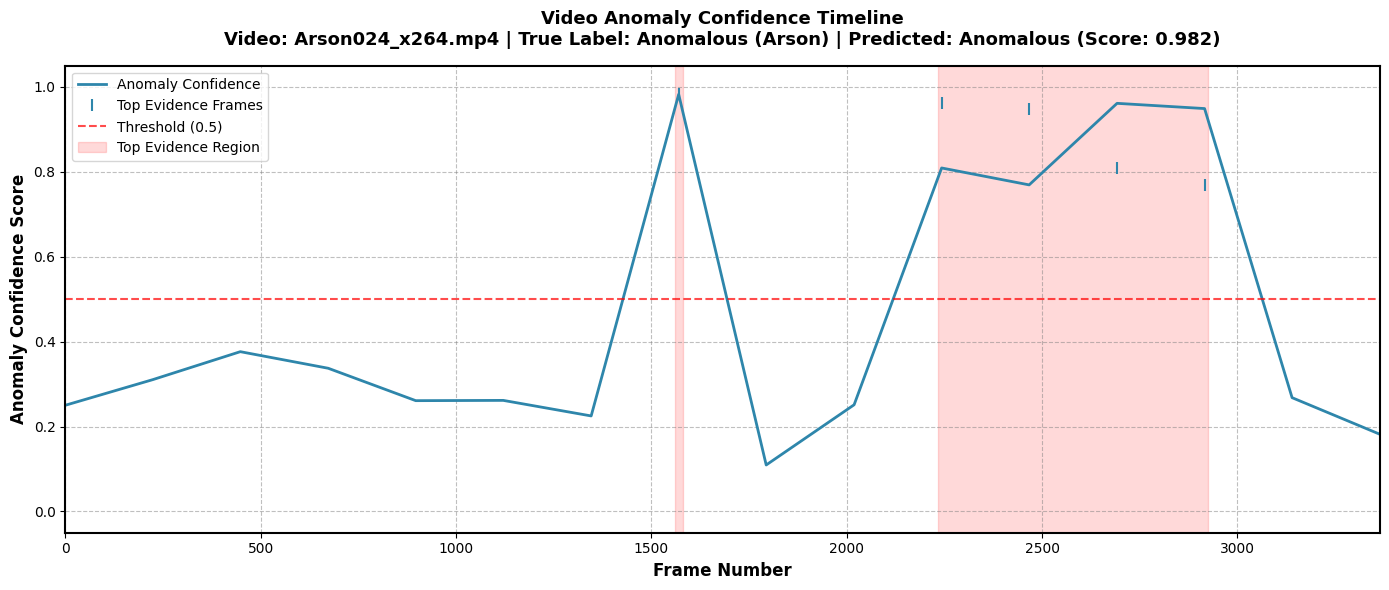


Video: Arson024_x264.mp4
True Label: Anomalous (Arson)
Overall Anomaly Score: 0.9824
Prediction: Anomalous

Top 5 Evidence Frames:
  #1: Frame 1570 (Confidence: 0.9824)
  #2: Frame 2692 (Confidence: 0.8090)
  #3: Frame 2916 (Confidence: 0.7692)
  #4: Frame 2243 (Confidence: 0.9612)
  #5: Frame 2467 (Confidence: 0.9489)



In [54]:
plot_video_confidence_timeline("Arson024_x264.mp4", model_s1, test_ds_s1)

In [15]:
# --- STAGE 2 DATASET ---
# Standard ImageFolder works because we organized data into folders by class
from torchvision.datasets import ImageFolder

transform_s2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_ds_s2 = ImageFolder(os.path.join(STAGE_2_DATA_ROOT, "Train"), transform=transform_s2)
test_ds_s2 = ImageFolder(os.path.join(STAGE_2_DATA_ROOT, "Test"), transform=transform_s2)

train_loader_s2 = DataLoader(train_ds_s2, batch_size=32, shuffle=True)
test_loader_s2 = DataLoader(test_ds_s2, batch_size=32, shuffle=False)

num_classes_s2 = len(train_ds_s2.classes)
print(f"Stage 2 Classes: {train_ds_s2.classes}")

# --- STAGE 2 MODEL: Vision Transformer ---
# Using a pretrained ViT
model_s2 = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)

# Modify the head for our number of crime classes
model_s2.heads.head = nn.Linear(model_s2.heads.head.in_features, num_classes_s2)
model_s2 = model_s2.to(DEVICE)

optimizer_s2 = optim.AdamW(model_s2.parameters(), lr=3e-5) # Lower LR for ViT fine-tuning
criterion_s2 = nn.CrossEntropyLoss()

# --- TRAINING LOOP STAGE 2 ---
def train_stage2(epochs=1):
    model_s2.train()
    history = {'train_loss': [], 'train_acc': [], 'train_f1': []}
    
    for epoch in range(epochs):
        epoch_loss = 0
        all_preds = []
        all_labels = []
        
        loop = tqdm(train_loader_s2, desc=f"Stage 2 Epoch {epoch+1}")
        for images, labels in loop:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer_s2.zero_grad()
            outputs = model_s2(images)
            loss = criterion_s2(outputs, labels)
            
            loss.backward()
            optimizer_s2.step()
            
            epoch_loss += loss.item()
            
            # Track predictions for metrics
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            loop.set_postfix(loss=loss.item())
        
        # Calculate epoch metrics
        avg_loss = epoch_loss / len(train_loader_s2)
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        
        history['train_loss'].append(avg_loss)
        history['train_acc'].append(accuracy)
        history['train_f1'].append(f1)
        
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Acc: {accuracy:.4f}, F1: {f1:.4f}")
    
    return history

print("Starting Stage 2 Training...")
stage2_history = train_stage2(epochs=6)

Stage 2 Classes: ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']
Starting Stage 2 Training...


Stage 2 Epoch 1: 100%|██████████| 238/238 [01:37<00:00,  2.44it/s, loss=0.125]


Epoch 1/6 - Loss: 1.0211, Acc: 0.7278, F1: 0.7213


Stage 2 Epoch 2: 100%|██████████| 238/238 [01:20<00:00,  2.95it/s, loss=0.0159]


Epoch 2/6 - Loss: 0.0921, Acc: 0.9858, F1: 0.9858


Stage 2 Epoch 3: 100%|██████████| 238/238 [01:20<00:00,  2.95it/s, loss=0.00579]


Epoch 3/6 - Loss: 0.0242, Acc: 0.9954, F1: 0.9954


Stage 2 Epoch 4: 100%|██████████| 238/238 [01:21<00:00,  2.94it/s, loss=0.0042] 


Epoch 4/6 - Loss: 0.0149, Acc: 0.9964, F1: 0.9965


Stage 2 Epoch 5: 100%|██████████| 238/238 [01:21<00:00,  2.93it/s, loss=0.00187]


Epoch 5/6 - Loss: 0.0110, Acc: 0.9968, F1: 0.9968


Stage 2 Epoch 6: 100%|██████████| 238/238 [01:20<00:00,  2.95it/s, loss=0.00127]


Epoch 6/6 - Loss: 0.0089, Acc: 0.9968, F1: 0.9968


Stage 2 Test Accuracy: 36.95%
Stage 2 Test F1 Score: 0.3536


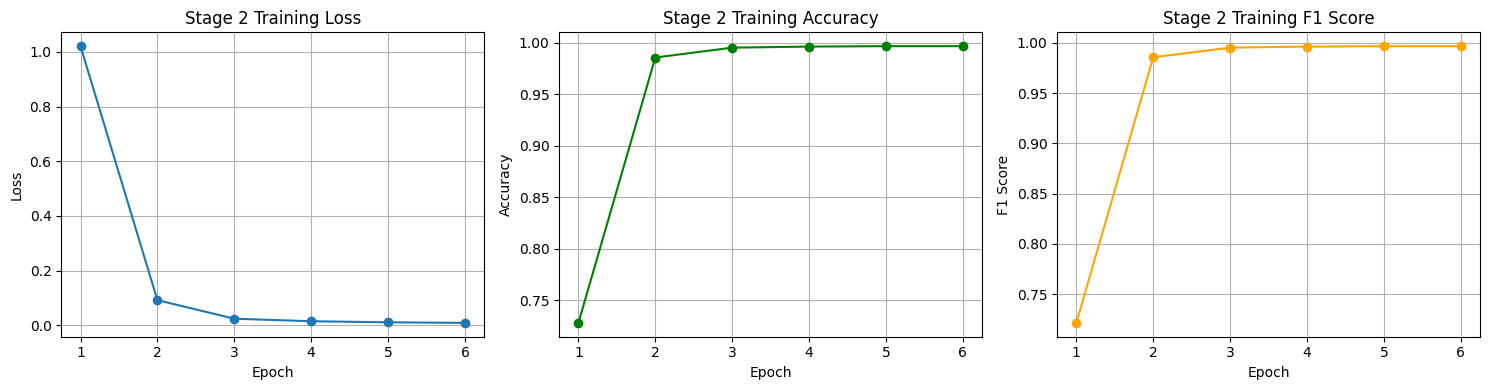

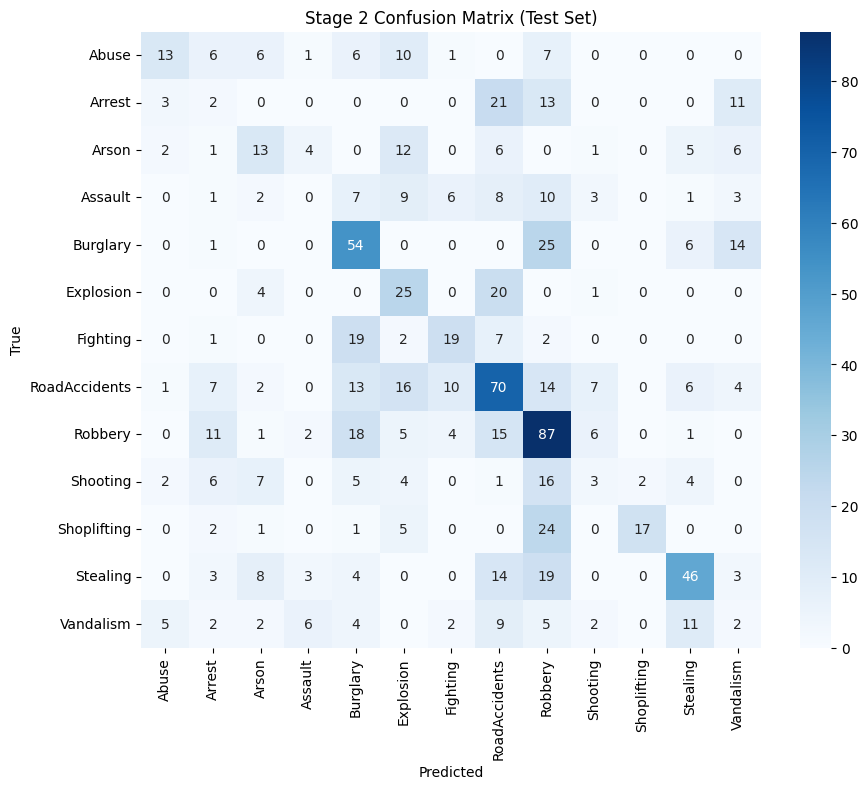

In [ ]:
# --- STAGE 2 EVALUATION AND VISUALIZATION ---

def evaluate_stage2(loader, model, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    
    return acc, f1, cm

# Evaluate on test set
test_acc, test_f1, test_cm = evaluate_stage2(test_loader_s2, model_s2, train_ds_s2.classes)
print(f"Stage 2 Test Accuracy: {test_acc*100:.2f}%")
print(f"Stage 2 Test F1 Score: {test_f1:.4f}")

# Plot training metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss plot
axes[0].plot(range(1, len(stage2_history['train_loss'])+1), stage2_history['train_loss'], marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Stage 2 Training Loss')
axes[0].grid(True)

# Accuracy plot
axes[1].plot(range(1, len(stage2_history['train_acc'])+1), stage2_history['train_acc'], marker='o', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Stage 2 Training Accuracy')
axes[1].grid(True)

# F1 Score plot
axes[2].plot(range(1, len(stage2_history['train_f1'])+1), stage2_history['train_f1'], marker='o', color='orange')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('Stage 2 Training F1 Score')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(test_cm, annot=True, fmt='d', xticklabels=train_ds_s2.classes, yticklabels=train_ds_s2.classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Stage 2 Confusion Matrix (Frame Level on Test Set)')
plt.show()

Frame-level Test Accuracy: 39.16%


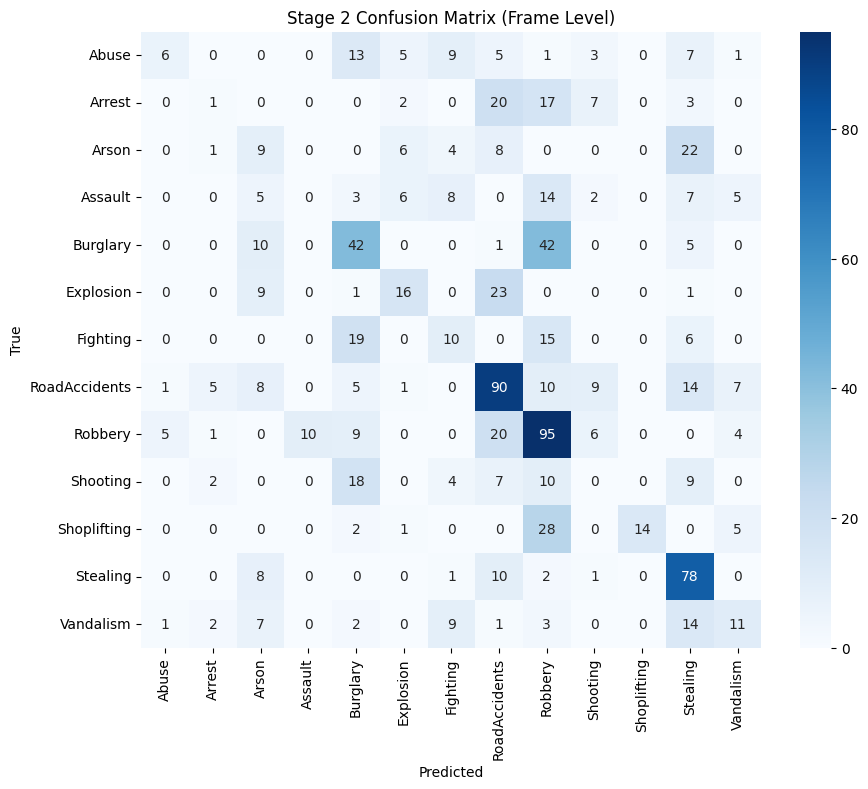

Visualizing a pipeline prediction...


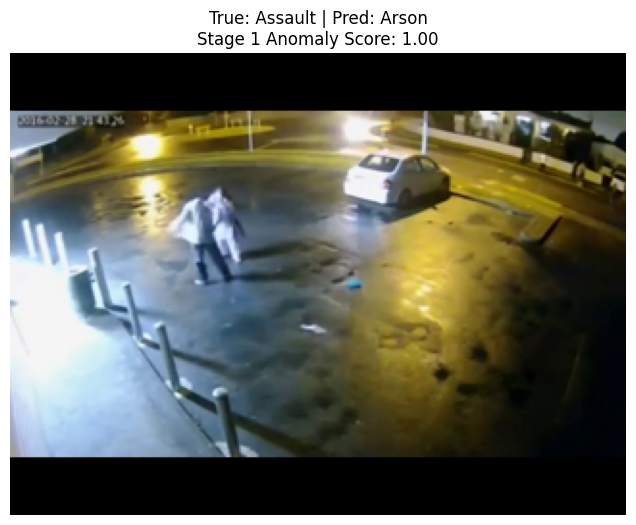

In [ ]:

# --- VISUALIZATION OF PIPELINE ---
# Let's show a video and the top frame selected
def visualize_pipeline_sample():
    # Grab a sample from Stage 1 Test Set
    dataset = test_ds_s1
    idx = np.random.randint(len(dataset))
    video, label, path, original_class = dataset[idx]
    
    if original_class == NORMAL_CLASS_NAME:
        print("Selected Normal video, skipping viz (looking for crime)...")
        return

    # 1. Run Stage 1
    model_s1.eval()
    with torch.no_grad():
        video_input = video.unsqueeze(0).to(DEVICE)
        vid_score, seg_scores = model_s1(video_input)
    
    # Get Top Frame Index
    best_seg_idx = torch.argmax(seg_scores[0]).item()
    
    # 2. Extract that frame image
    # (Re-extracting manually for viz)
    cap = cv2.VideoCapture(path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames-1, NUM_SEGMENTS).astype(int)
    best_frame_idx = frame_indices[best_seg_idx]
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, best_frame_idx)
    ret, frame_bgr = cap.read()
    cap.release()
    
    if not ret: return
    
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    
    # 3. Run Stage 2 on that frame
    # Preprocess
    pil_img = Image.fromarray(frame_rgb)
    img_tensor = transform_s2(pil_img).unsqueeze(0).to(DEVICE)
    
    model_s2.eval()
    with torch.no_grad():
        out = model_s2(img_tensor)
        probs = torch.nn.functional.softmax(out, dim=1)
        top_prob, pred_idx = torch.max(probs, 1)
        pred_class = train_ds_s2.classes[pred_idx.item()]
    
    # Plot
    plt.figure(figsize=(8,6))
    plt.imshow(frame_rgb)
    plt.title(f"True: {original_class} | Pred: {pred_class}\nStage 1 Anomaly Score: {vid_score.item():.2f}")
    plt.axis('off')
    plt.show()

print("Visualizing a pipeline prediction...")
visualize_pipeline_sample()

STAGE 3: VIDEO-LEVEL CLASSIFICATION

Stage 3 Video-Level Test Accuracy: 36.84%
Stage 3 Video-Level Test F1 Score: 0.3438
Total Videos Evaluated: 95

Sample Video Predictions:
Video Name                               True            Predicted       Frame Votes
------------------------------------------------------------------------------------------
Abuse003_x264                            Abuse           Abuse           {'Abuse': 9, 'Arson': 1}
Abuse011_x264                            Abuse           Arrest          {'Arrest': 5, 'Abuse': 2, 'Burglary': 3}
Abuse013_x264                            Abuse           Explosion       {'Explosion': 6, 'Abuse': 2, 'Assault': 1, 'Arrest': 1}
Abuse039_x264                            Abuse           Robbery         {'Burglary': 3, 'Robbery': 7}
Abuse047_x264                            Abuse           Arson           {'Arson': 5, 'Explosion': 4, 'Fighting': 1}
Arrest013_x264                           Arrest          Vandalism       {'Vandalism': 1

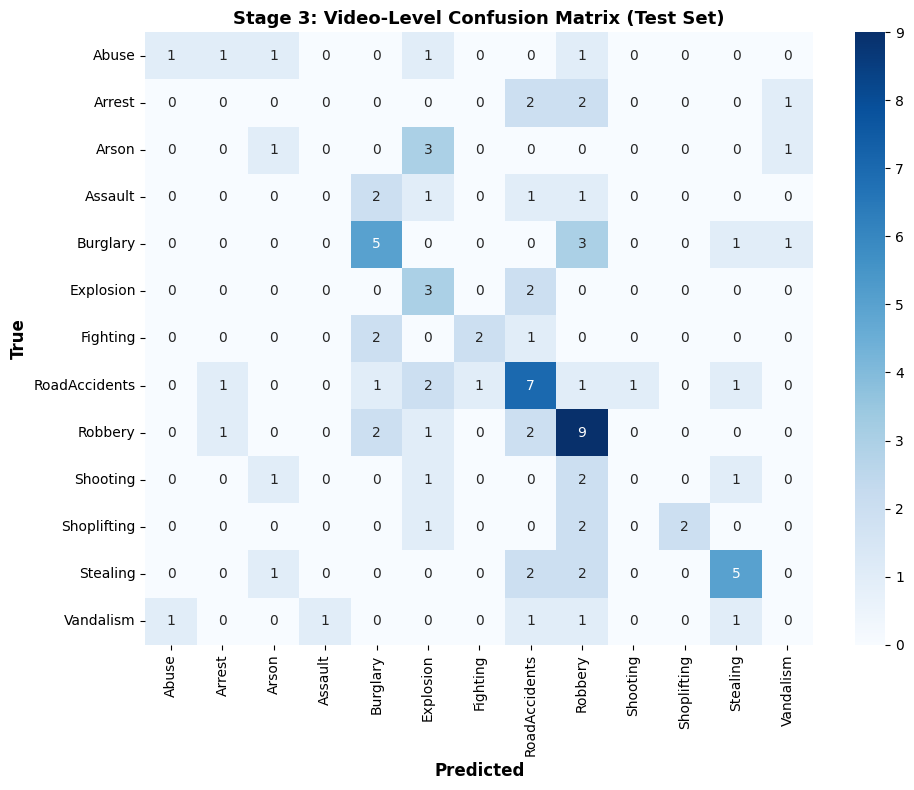


PERFORMANCE COMPARISON
Stage 2 (Frame-Level) Accuracy: 36.95%
Stage 3 (Video-Level) Accuracy: 36.84%

Stage 2 (Frame-Level) F1 Score: 0.3536
Stage 3 (Video-Level) F1 Score: 0.3438


In [49]:
# --- STAGE 3: VIDEO-LEVEL CLASSIFICATION ---

def aggregate_frames_to_video_predictions(model, dataset_root, split_name, classes):
    """
    Aggregate frame-level predictions to video-level predictions.
    For each video, takes the most common predicted class across its frames.
    
    Args:
        model: Trained Stage 2 model
        dataset_root: Root directory containing extracted frames (STAGE_2_DATA_ROOT)
        split_name: "Train" or "Test"
        classes: List of class names from Stage 2
    
    Returns:
        video_predictions: Dict mapping video name to predicted class
        video_true_labels: Dict mapping video name to true class
        video_frame_predictions: Dict mapping video name to list of frame predictions
    """
    model.eval()
    
    split_path = os.path.join(dataset_root, split_name)
    video_predictions = {}
    video_true_labels = {}
    video_frame_predictions = {}
    
    # Iterate through each class folder
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if not os.path.isdir(class_path):
            continue
        
        # Group frames by video name
        video_frames = {}
        for frame_file in os.listdir(class_path):
            if not frame_file.endswith('.jpg'):
                continue
            
            # Extract video name (format: VideoName_rankN.jpg)
            video_name = '_'.join(frame_file.split('_')[:-1])  # Remove _rankN.jpg
            
            if video_name not in video_frames:
                video_frames[video_name] = []
            
            video_frames[video_name].append(os.path.join(class_path, frame_file))
        
        # Process each video
        for video_name, frame_paths in video_frames.items():
            frame_preds = []
            
            with torch.no_grad():
                for frame_path in frame_paths:
                    # Load and preprocess frame
                    img = Image.open(frame_path).convert('RGB')
                    img_tensor = transform_s2(img).unsqueeze(0).to(DEVICE)
                    
                    # Get prediction
                    output = model(img_tensor)
                    _, pred_idx = torch.max(output, 1)
                    pred_class = classes[pred_idx.item()]
                    
                    frame_preds.append(pred_class)
            
            # Store frame predictions for this video
            video_frame_predictions[video_name] = frame_preds
            
            # Aggregate: Most common prediction
            from collections import Counter
            most_common_pred = Counter(frame_preds).most_common(1)[0][0]
            
            video_predictions[video_name] = most_common_pred
            video_true_labels[video_name] = class_name
    
    return video_predictions, video_true_labels, video_frame_predictions


def evaluate_video_level(video_predictions, video_true_labels, classes):
    """
    Evaluate video-level classification performance.
    
    Args:
        video_predictions: Dict mapping video name to predicted class
        video_true_labels: Dict mapping video name to true class
        classes: List of class names
    
    Returns:
        accuracy, f1_score, confusion_matrix
    """
    # Convert to lists for sklearn metrics
    true_labels = []
    pred_labels = []
    
    for video_name in video_predictions.keys():
        true_labels.append(video_true_labels[video_name])
        pred_labels.append(video_predictions[video_name])
    
    # Calculate metrics
    acc = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    
    # Confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=classes)
    
    return acc, f1, cm, true_labels, pred_labels


# Run Stage 3 evaluation on test set
print("=" * 70)
print("STAGE 3: VIDEO-LEVEL CLASSIFICATION")
print("=" * 70)

video_preds_test, video_true_test, video_frame_preds_test = aggregate_frames_to_video_predictions(
    model_s2, STAGE_2_DATA_ROOT, "Test", train_ds_s2.classes
)

video_acc, video_f1, video_cm, true_labels, pred_labels = evaluate_video_level(
    video_preds_test, video_true_test, train_ds_s2.classes
)

print(f"\nStage 3 Video-Level Test Accuracy: {video_acc*100:.2f}%")
print(f"Stage 3 Video-Level Test F1 Score: {video_f1:.4f}")
print(f"Total Videos Evaluated: {len(video_preds_test)}")

# Show some example predictions
print("\nSample Video Predictions:")
print(f"{'Video Name':<40} {'True':<15} {'Predicted':<15} {'Frame Votes'}")
print("-" * 90)
for i, (video_name, pred_class) in enumerate(list(video_preds_test.items())[:10]):
    true_class = video_true_test[video_name]
    frame_preds = video_frame_preds_test[video_name]
    from collections import Counter
    vote_summary = dict(Counter(frame_preds))
    print(f"{video_name:<40} {true_class:<15} {pred_class:<15} {vote_summary}")

# Visualize video-level confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(video_cm, annot=True, fmt='d', xticklabels=train_ds_s2.classes, 
            yticklabels=train_ds_s2.classes, cmap='Blues')
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('True', fontsize=12, fontweight='bold')
plt.title('Stage 3: Video-Level Confusion Matrix (Test Set)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Compare Stage 2 (frame-level) vs Stage 3 (video-level) performance
print("\n" + "=" * 70)
print("PERFORMANCE COMPARISON")
print("=" * 70)
print(f"Stage 2 (Frame-Level) Accuracy: {test_acc*100:.2f}%")
print(f"Stage 3 (Video-Level) Accuracy: {video_acc*100:.2f}%")
print(f"\nStage 2 (Frame-Level) F1 Score: {test_f1:.4f}")
print(f"Stage 3 (Video-Level) F1 Score: {video_f1:.4f}")
print("=" * 70)